## Importes

In [1]:
# Utils
import pandas as pd
import numpy as np
import warnings
from pathlib import Path

# Modeling / Evaluating / DataPrep
import sklearn
from sklearn.ensemble import ExtraTreesClassifier

# Visualization
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## Configurações

In [2]:
data_path =  Path('../data/02_outputs')

## Preparação dos Dados

In [3]:
# checando dados missing
df = pd.read_csv(data_path / '01_matches_eco_score.csv')

df.columns[df.isnull().any()]

Index(['away_rank', 'away_score', 'rank_diff', 'score_diff'], dtype='object')

In [4]:
# checando dados missing
df.columns[df.isnull().any()]

Index(['away_rank', 'away_score', 'rank_diff', 'score_diff'], dtype='object')

In [5]:
# vamos excluir esse Registro
df[df['home_team_name'] == 'Serbia and Montenegro']

,match_date,home_team_name,away_team_name,home_team_score,away_team_score,year,home_rank,home_score,away_rank,away_score,home_n_participation,away_n_participation,home_winner,draw,away_winner,rank_diff,team_score_diff,score_diff,best_rank_winner
649,2006-06-11,Serbia and Montenegro,Netherlands,0,1,2006,40.0,1690.0,4.0,1991.0,0,7,0,0,1,36.0,-1,-301.0,0


In [6]:
df.dropna(inplace=True)

In [7]:
df.dtypes

match_date               object
home_team_name           object
away_team_name           object
home_team_score           int64
away_team_score           int64
year                      int64
home_rank               float64
home_score              float64
away_rank               float64
away_score              float64
home_n_participation      int64
away_n_participation      int64
home_winner               int64
draw                      int64
away_winner               int64
rank_diff               float64
team_score_diff           int64
score_diff              float64
best_rank_winner          int64
dtype: object

In [8]:
df_to_model = df.copy()
df_to_model['participation_diff'] = df_to_model['home_n_participation'] - df_to_model['away_n_participation']

df_to_model['target'] = df_to_model.apply(lambda x: 
                                          -1 if x['away_winner'] == 1 else 0 if x['draw'] == 1 else 1, axis=1)

df_to_model.drop(['away_winner', 'draw', 'home_winner',
                  'home_team_score', 'away_team_score', 'team_score_diff',
                  'match_date', 'home_team_name', 'away_team_name', 
                  'best_rank_winner'], axis=1, inplace=True)

In [9]:
df_to_model

,year,home_rank,home_score,away_rank,away_score,home_n_participation,away_n_participation,rank_diff,score_diff,participation_diff,target
0,1930,35.0,1566.0,41.0,1497.0,0,0,-6.0,69.0,0,1
1,1930,14.0,1762.0,31.0,1593.0,0,0,-17.0,169.0,0,1
2,1930,25.0,1658.0,9.0,1890.0,0,0,16.0,-232.0,0,1
3,1930,37.0,1544.0,42.0,1496.0,0,0,-5.0,48.0,0,1
4,1930,1.0,2062.0,35.0,1566.0,0,0,-34.0,496.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
895,2018,30.0,1753.0,10.0,1925.0,3,4,20.0,-172.0,-1,0
896,2018,2.0,2094.0,3.0,2035.0,14,12,-1.0,59.0,2,1
897,2018,10.0,1925.0,7.0,1960.0,4,14,3.0,-35.0,-10,1
898,2018,3.0,2035.0,7.0,1960.0,12,14,-4.0,75.0,-2,1


## Feature Selection

In [10]:
array = df_to_model.values

# Separando o array em componentes de input e output
X = array[:,:-1]
Y = array[:,-1]

# Criação do Modelo - Feature Selection
modelo = ExtraTreesClassifier(random_state = 123)
modelo.fit(X, Y)

# Print dos Resultados
res = [[round(modelo.feature_importances_[i],4),df_to_model.columns[i]] for i in range(len(df_to_model.columns)-1)]
rescols = [x[1] for x in res]
res.sort(); res

[[0.0794, 'home_n_participation'],
 [0.0835, 'away_rank'],
 [0.0851, 'away_n_participation'],
 [0.0877, 'participation_diff'],
 [0.0988, 'home_score'],
 [0.0992, 'away_score'],
 [0.1019, 'home_rank'],
 [0.1041, 'year'],
 [0.1145, 'rank_diff'],
 [0.1459, 'score_diff']]

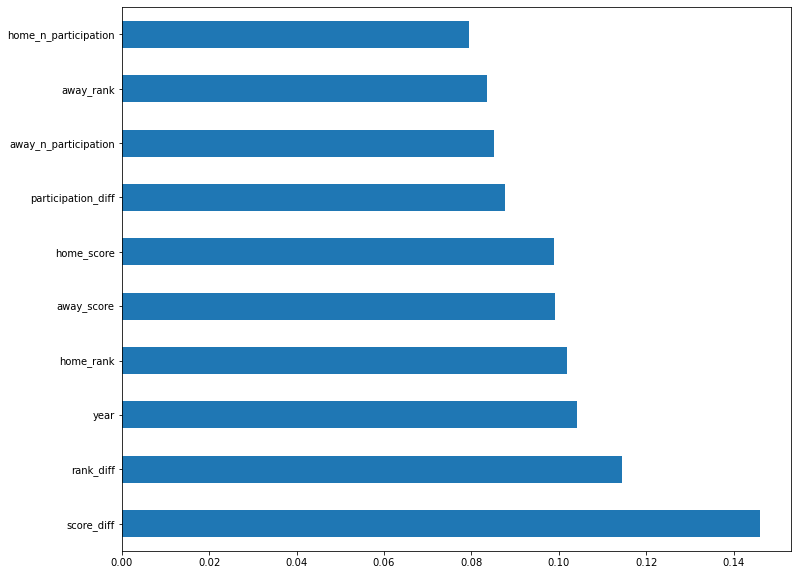

In [11]:
# Plot dos Resultados
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(12)

feat_importances = pd.Series(modelo.feature_importances_, index=rescols)
feat_importances.nlargest(38).plot(kind='barh');

As Variáveis apontadas mais importantes foram a diferença entre as pontuações no ranking ELO e a difernça posicional no ranking, porém como não existe muita discrepância, todas as variáveis serão mantidas.

In [13]:
# Salvando os dados
df_to_model.to_csv(data_path / '02_to_model_v1.csv', index=False)